In [326]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [327]:
# Importing the dataset
df = pd.read_csv('continuous dataset.csv', parse_dates=['datetime'])
df.set_index('datetime', inplace=True)
df.tail()

,nat_demand,T2M_toc,QV2M_toc,TQL_toc,W2M_toc,T2M_san,QV2M_san,TQL_san,W2M_san,T2M_dav,QV2M_dav,TQL_dav,W2M_dav,Holiday_ID,holiday,school
datetime,,,,,,,,,,,,,,,,
2020-06-26 20:00:00,1128.5592,27.246545,0.020303,0.055511,9.289304,25.715295,0.019746,0.121552,1.990773,23.746545,0.018381,0.150879,2.444658,0,0,1
2020-06-26 21:00:00,1112.7488,27.099573,0.020395,0.053848,9.837504,25.552698,0.019632,0.153870,2.094459,23.693323,0.018320,0.156311,2.515814,0,0,1
2020-06-26 22:00:00,1081.5680,26.971155,0.020448,0.057251,10.262464,25.393030,0.019518,0.144531,2.396369,23.658655,0.018327,0.153259,2.800717,0,0,1
2020-06-26 23:00:00,1041.6240,26.867487,0.020464,0.064178,10.326567,25.258112,0.019403,0.108063,2.720871,23.601862,0.018358,0.152771,3.138132,0,0,1
2020-06-27 00:00:00,1013.5683,26.750330,0.020441,0.063965,10.198346,25.125330,0.019281,0.100189,2.785751,23.562830,0.018404,0.162598,3.286878,0,0,1


In [328]:
df.shape

(48048, 16)

In [329]:
# Print max and min date
print(df.index.min())  
print(df.index.max())

2015-01-03 01:00:00
2020-06-27 00:00:00


In [330]:
correlation_matrix = df.corr()
print("Correlation with nat_demand:\n", correlation_matrix['nat_demand'].sort_values(ascending=False))

selected_features = correlation_matrix['nat_demand'][abs(correlation_matrix['nat_demand']) > 0.1].index
filtered_data = df[selected_features]
filtered_data.head()

Correlation with nat_demand:
 nat_demand    1.000000
T2M_toc       0.652811
T2M_dav       0.648279
T2M_san       0.627024
W2M_san       0.191796
TQL_san       0.119038
W2M_toc       0.098435
TQL_toc       0.073109
TQL_dav       0.042037
school        0.040044
QV2M_san      0.022172
QV2M_dav     -0.002117
QV2M_toc     -0.036706
W2M_dav      -0.054802
Holiday_ID   -0.129834
holiday      -0.165673
Name: nat_demand, dtype: float64


,nat_demand,T2M_toc,T2M_san,TQL_san,W2M_san,T2M_dav,Holiday_ID,holiday
datetime,,,,,,,,
2015-01-03 01:00:00,970.3450,25.865259,23.482446,0.001855,10.328949,22.662134,0,0
2015-01-03 02:00:00,912.1755,25.899255,23.399255,0.001327,10.681517,22.578943,0,0
2015-01-03 03:00:00,900.2688,25.937280,23.343530,0.001428,10.874924,22.531030,0,0
2015-01-03 04:00:00,889.9538,25.957544,23.238794,0.002599,10.518620,22.512231,0,0
2015-01-03 05:00:00,893.6865,25.973840,23.075403,0.001729,9.733589,22.481653,0,0


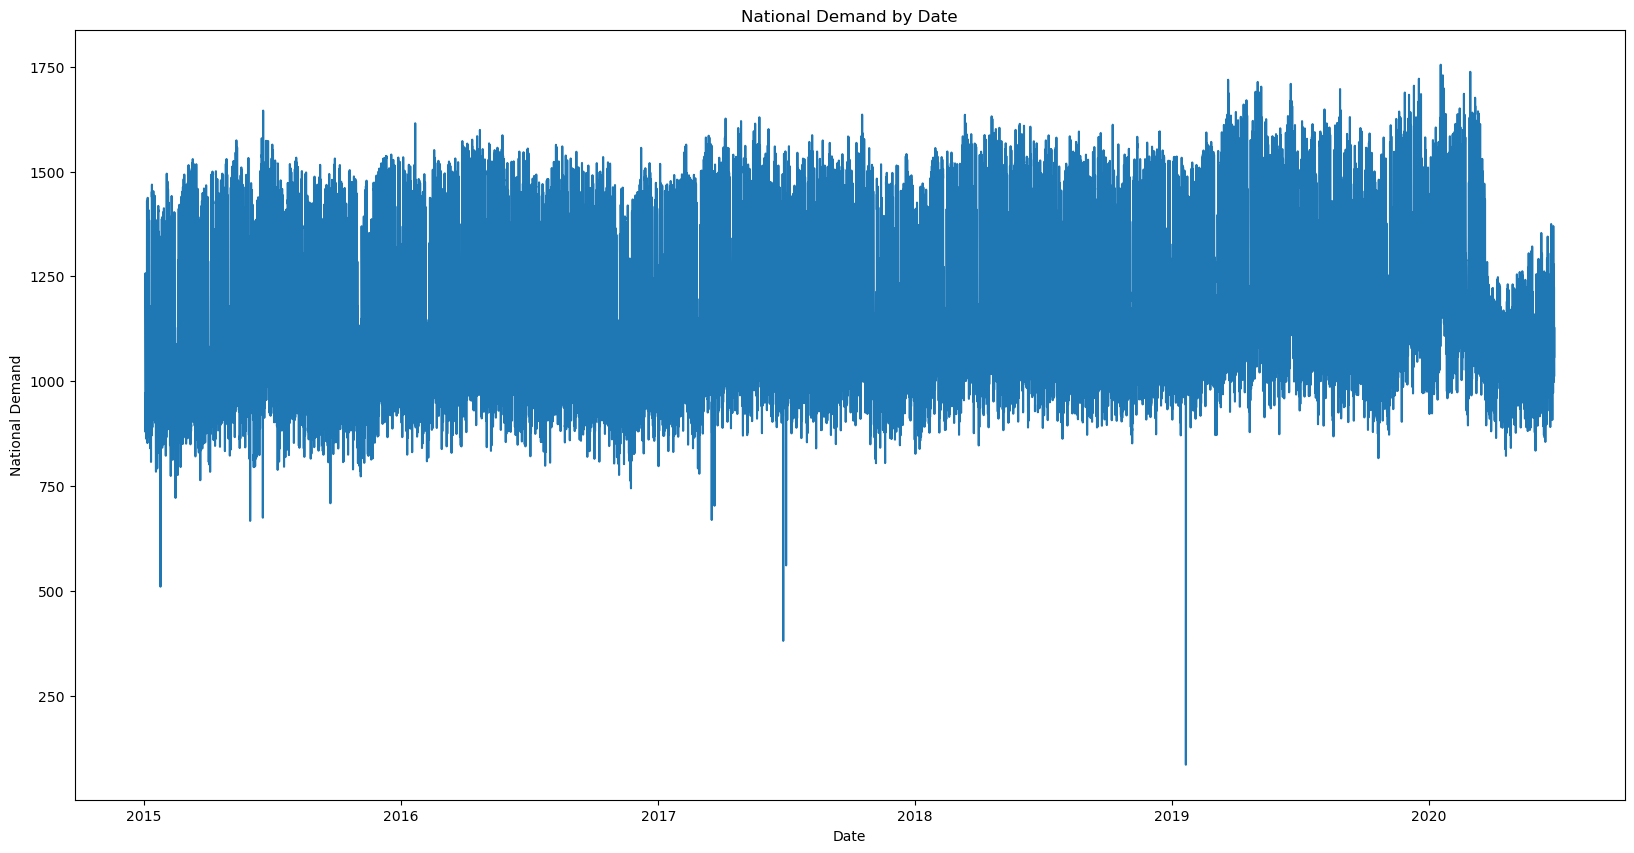

In [331]:
# Plotting the nat_demand by date and using a trendline to show the trend
plt.figure(figsize=(20,10))
plt.plot(filtered_data['nat_demand'])
plt.title('National Demand by Date')
plt.xlabel('Date')
plt.ylabel('National Demand')
plt.show()


In [332]:
filtered_data.shape

(48048, 8)

In [333]:
# Scaling the data
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(filtered_data)
scaled_data = pd.DataFrame(scaled_data, columns=filtered_data.columns, index=filtered_data.index)
scaled_data.head()


,nat_demand,T2M_toc,T2M_san,TQL_san,W2M_san,T2M_dav,Holiday_ID,holiday
datetime,,,,,,,,
2015-01-03 01:00:00,0.530130,0.240921,0.192620,0.003807,0.420437,0.191031,0.0,0.0
2015-01-03 02:00:00,0.495291,0.243734,0.188309,0.002718,0.434872,0.185206,0.0,0.0
2015-01-03 03:00:00,0.488160,0.246880,0.185422,0.002926,0.442791,0.181852,0.0,0.0
2015-01-03 04:00:00,0.481983,0.248557,0.179994,0.005340,0.428203,0.180535,0.0,0.0
2015-01-03 05:00:00,0.484218,0.249905,0.171528,0.003547,0.396060,0.178394,0.0,0.0


In [334]:
X = scaled_data.drop(columns=['nat_demand'])
y = scaled_data['nat_demand']

In [335]:
lasso = Lasso(alpha=0.001)
lasso.fit(X, y)
lasso_features = pd.Series(lasso.coef_, index=X.columns)
selected_lasso_features = lasso_features[lasso_features != 0].index
filtered_data = filtered_data[selected_lasso_features.tolist() + ['nat_demand']]

In [336]:
def create_sequences(data, target_column, timesteps=24):
    X, y = [], []
    for i in range(timesteps, len(data)):
        X.append(data.iloc[i-timesteps:i].drop(columns=[target_column]).values)
        y.append(data.iloc[i][target_column])
    return np.array(X), np.array(y)

timesteps = 24 
X, y = create_sequences(filtered_data, target_column='nat_demand', timesteps=timesteps)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [337]:
model = Sequential()
model.add(LSTM(units=8, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2]), kernel_regularizer=l2(0.001)))
model.add(Dropout(0.2))
model.add(LSTM(units=8, return_sequences=False, kernel_regularizer=l2(0.001)))
model.add(Dropout(0.2))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')

/Users/sakib/anaconda3/envs/advanced_ds/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [261]:
y_pred = lstm_model.predict(X_test)
for i in range(30):
    print(y_pred[-i], y_test[-i])

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
[0.61070997] [0.70099732]
[0.5745197] [0.37779579]
[0.5758864] [0.51290842]
[0.5853018] [0.42109892]
[0.5711033] [0.4318204]
[0.54043347] [0.50198954]
[0.56496805] [0.42171846]
[0.5857684] [0.39422108]
[0.5787903] [0.47671729]
[0.5598188] [0.41007173]
[0.52647024] [0.38334472]
[0.50737005] [0.34855118]
[0.5744609] [0.31029213]
[0.60649234] [0.28439329]
[0.6297346] [0.39823996]
[0.593934] [0.49959093]
[0.58361626] [0.43751654]
[0.56476825] [0.4402641]
[0.57374275] [0.35099809]
[0.585538] [0.34130317]
[0.56305534] [0.38690469]
[0.56503063] [0.31069666]
[0.6026141] [0.2962769]
[0.61923057] [0.31262333]
[0.59459454] [0.44597063]
[0.605487] [0.48955806]
[0.59010905] [0.38208735]
[0.5676509] [0.45888749]
[0.5524177] [0.31705438]
[0.5750649] [0.29736494]


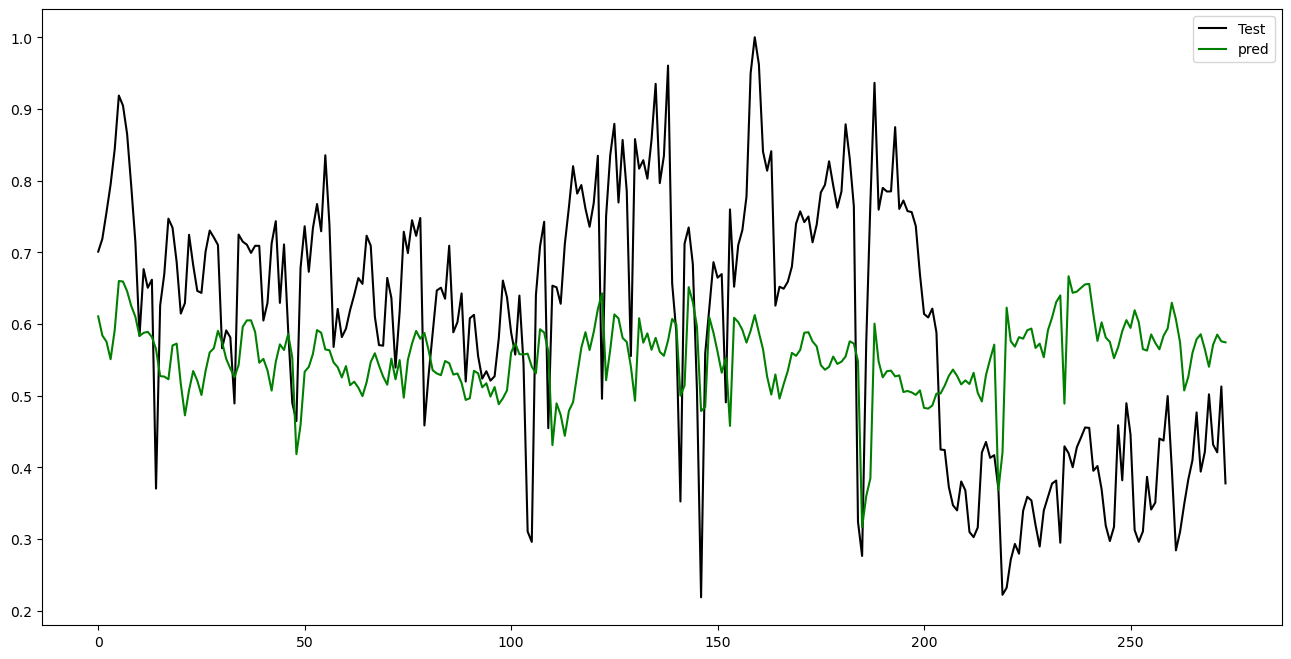

In [262]:
plt.figure(figsize=(16,8))
plt.plot(y_test, color = 'black', label = 'Test')
plt.plot(y_pred, color = 'green', label = 'pred')
plt.legend()
plt.show()

In [263]:
# Getting mae and rmse
from sklearn.metrics import mean_absolute_error, mean_squared_error
mae =  round(mean_absolute_error(y_test, y_pred),2)
rmse = round(np.sqrt(mean_squared_error(y_test, y_pred)))
print(f'MAE: {mae}')
print(f'RMSE: {rmse}')


MAE: 0.17
RMSE: 0
